
Đánh giá mô hình trên tập Test:
Test MAE: 0.0541
Test MSE: 0.0068
Test RMSE: 0.0826
Test R2 Score: 0.8095

Đánh giá mô hình trên tập Train
Train MAE: 0.0242
Train MSE: 0.0017
Train RMSE: 0.0408
Train R2 Score: 0.9469


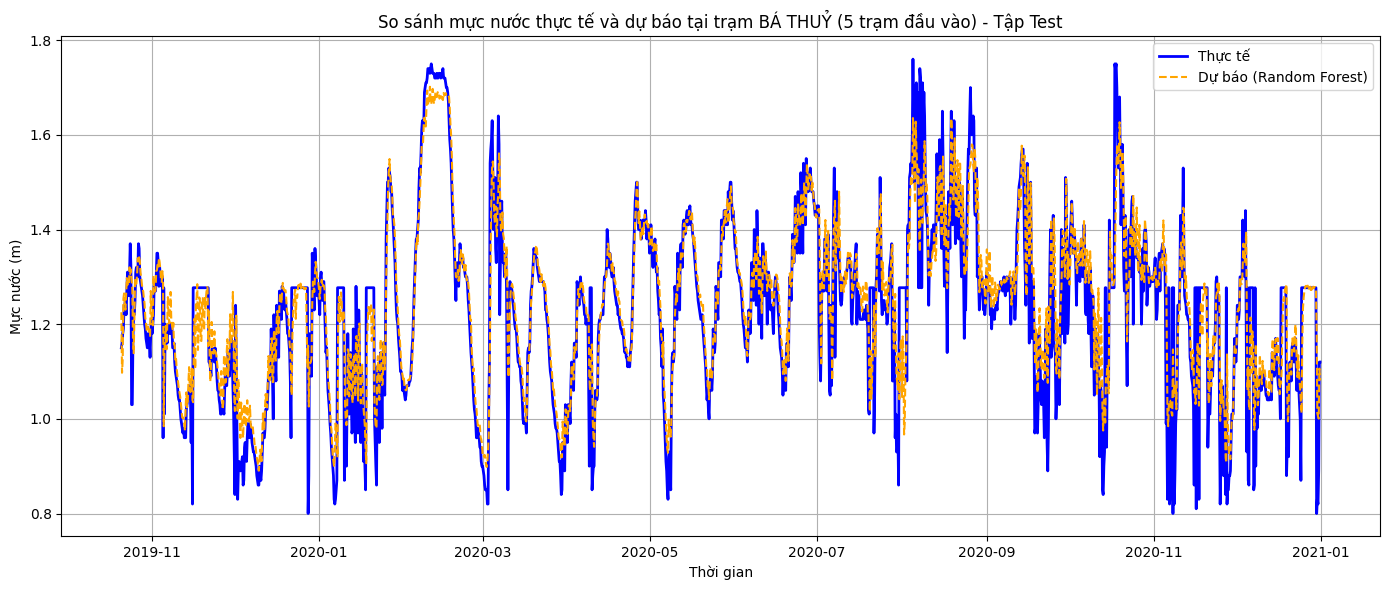

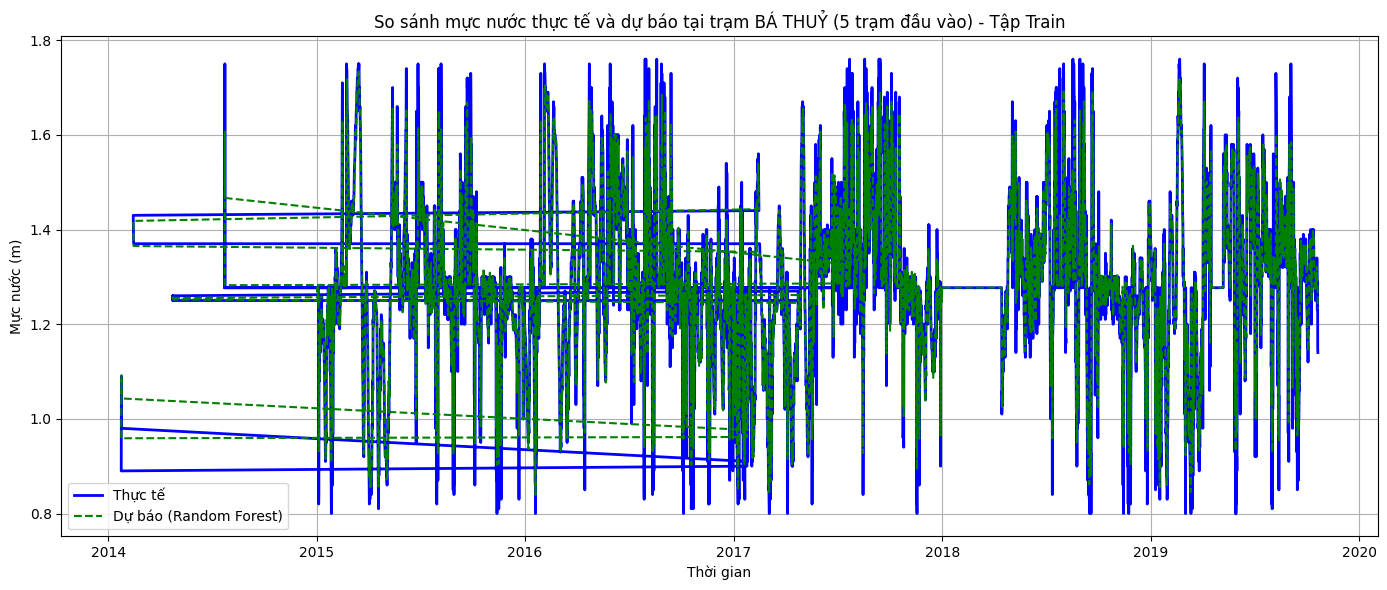

In [ ]:
#Dự báo từ 5 trạm(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


# 2. Chọn features và target(input,output)
feature_cols = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN']
target_col = 'BÁ THUỶ'

# Loại bỏ giá trị không hợp lệ
df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. Tạo các đặc trưng trễ thời gian
def create_lagged_features(data, feature_cols, target_col, n_lags=3):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

n_lags = 3
df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags)

# 4. Chuẩn bị dữ liệu train/test
X = df_lagged.drop(columns=[target_col])
y = df_lagged[target_col]

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42
)

# 5. Huấn luyện mô hình Random Forest
rf_model_4tram = RandomForestRegressor(
    n_estimators=400, #số lượng cây trong rừng - tăng số cây giúp cải thiện độ chính xác, đến một mức nhất định
    max_depth=15, #Giới hạn độ sâu cây để tránh overfitting (quá khớp)
    min_samples_split=5,#Một node chỉ được chia khi có ít nhất 5 mẫu - tăng tính tổng quát
    min_samples_leaf=2, #Một lá phải có ít nhất 2 mẫu - giúp cây không quá phân nhánh nhỏ
    max_features='sqrt',#Số lượng feature được chọn ngẫu nhiên khi chia nhánh - 'sqrt' hiệu quả cho bài toán hồi quy
    random_state=42,# Giúp tái lập kết quả (reproducibility)
    n_jobs=-1# Dùng tất cả các lõi CPU để tăng tốc độ huấn luyện
)
rf_model_4tram.fit(X_train, y_train)

# 6. Đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Dự đoán trên tập TRAIN 
y_train_pred_scaled = rf_model_4tram.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Dự đoán trên tập TEST 
y_test_pred_scaled = rf_model_4tram.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()



# In kết quả
mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test_orig, y_test_pred)
print("\nĐánh giá mô hình trên tập Test:")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2 Score: {r2_test:.4f}")

mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_orig, y_train_pred)
print("\nĐánh giá mô hình trên tập Train")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")


# Tạo trục thời gian tương ứng
dates_test = df_lagged.index[-len(y_test):]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, y_test_pred, label='Dự báo (Random Forest)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (5 trạm đầu vào) - Tập Test')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


dates_train = df_lagged.index[:len(y_train)]

plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, y_train_pred, label='Dự báo (Random Forest)', color='green', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (5 trạm đầu vào) - Tập Train')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [50]:

# Lấy index thời gian tương ứng
train_index = df_lagged.index[:len(y_train_orig)]
test_index = df_lagged.index[-len(y_test_orig):]

# Tạo DataFrame kết quả cho Train
df_train = pd.DataFrame({
    'Thời gian': train_index,
    'Giá trị thực tế (BÁ THỦY)': y_train_orig,
    'Giá trị dự báo (BÁ THỦY)': y_train_pred,
    
})

# Tạo DataFrame kết quả cho Test
df_test = pd.DataFrame({
    'Thời gian': test_index,
    'Giá trị thực tế (BÁ THỦY)': y_test_orig,
    'Giá trị dự báo (BÁ THỦY)': y_test_pred,
    
})

# Gộp Train + Test
df_full = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df_full.set_index('Thời gian', inplace=True)

# In vài dòng đầu
print("\nDữ liệu dự báo gộp (Train + Test):")
print(df_full.head())

# Xuất ra Excel
df_full.to_excel("../Data/du_bao_BA_THUY_RF_4tram.xlsx")


Dữ liệu dự báo gộp (Train + Test):
                     Giá trị thực tế (BÁ THỦY)  Giá trị dự báo (BÁ THỦY)
Thời gian                                                               
2015-01-01 19:00:00                   1.277022                  1.278777
2015-01-02 01:00:00                   1.277022                  1.277794
2015-01-02 07:00:00                   1.277022                  1.276455
2015-01-02 13:00:00                   1.277022                  1.268776
2015-01-02 19:00:00                   1.277022                  1.278636



Đánh giá hiệu suất mô hình trên tập Test:
Test MAE: 0.0516
Test MSE: 0.0071
Test RMSE: 0.0846
Test R2 Score: 0.8004

Đánh giá hiệu suất mô hình trên tập Train:
Train MAE: 0.0303
Train MSE: 0.0029
Train RMSE: 0.0535
Train R2 Score: 0.9089


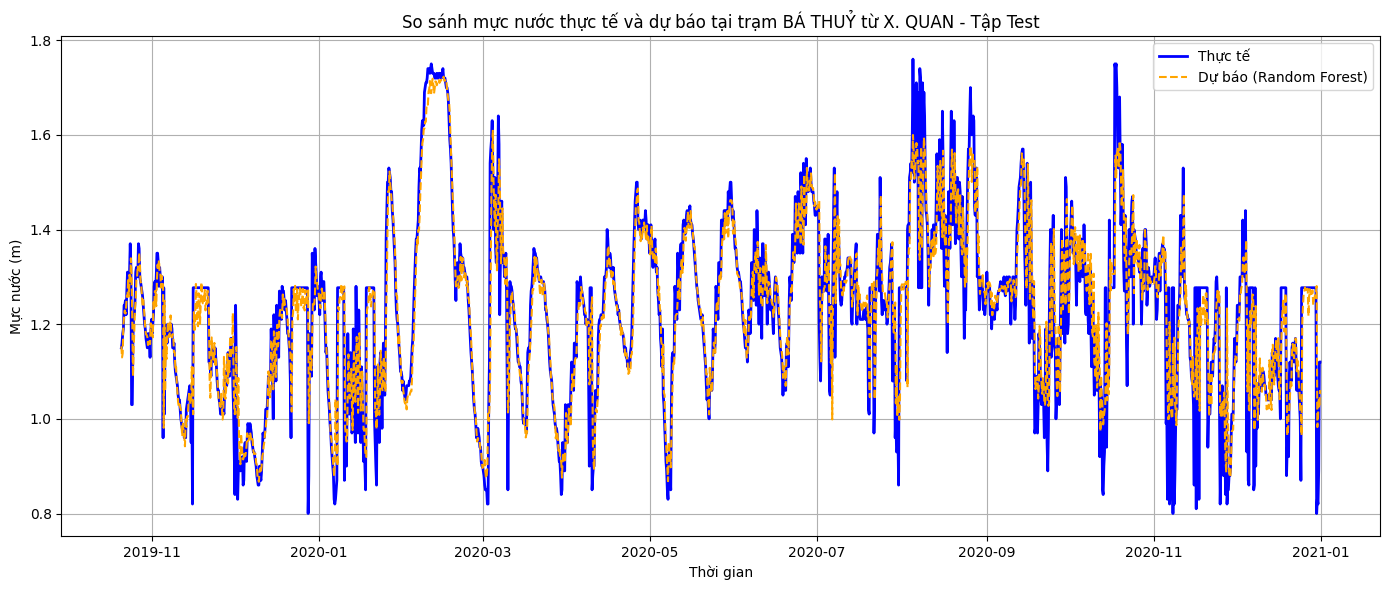

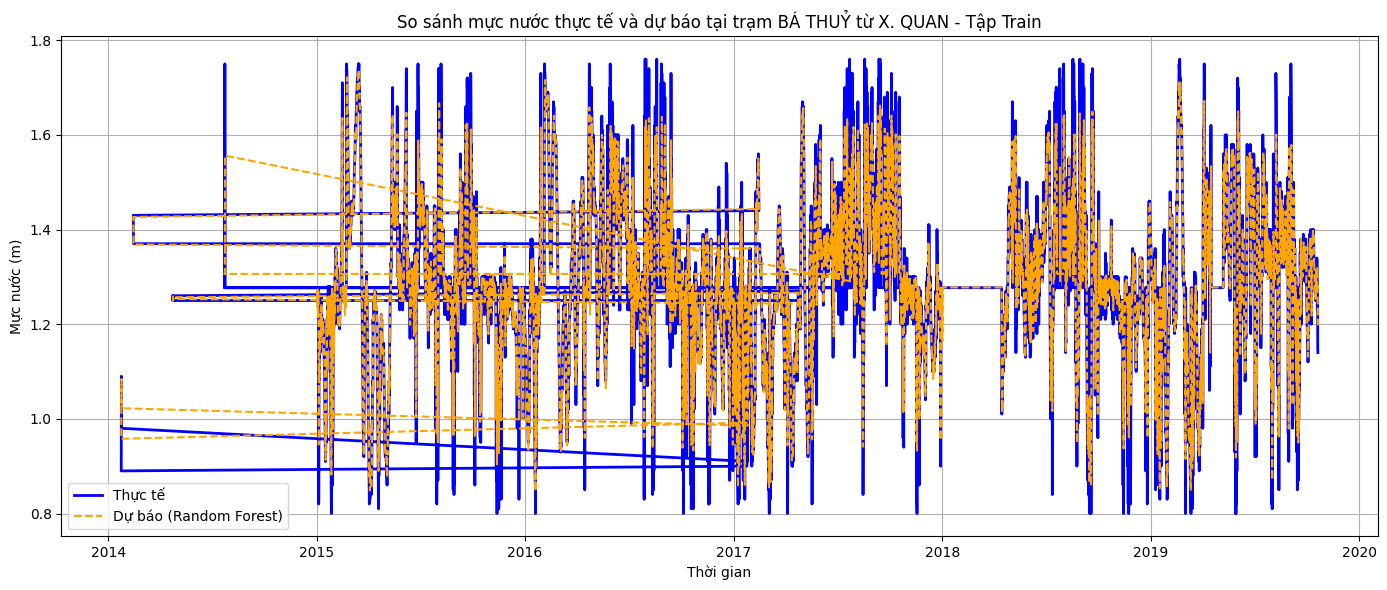

In [6]:
#Dự báo từ X.Quan(3)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. Chọn features và target
feature_cols = ['X. QUAN']
target_col = 'BÁ THUỶ'
df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. Tạo đặc trưng trễ
def create_lagged_features(data, feature_cols, target_col, n_lags=3):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

n_lags = 3
df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags)

# 4. Chuẩn bị dữ liệu
X = df_lagged.drop(columns=[target_col])
y = df_lagged[target_col]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42
)

# 6. Huấn luyện mô hình
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


# 7. Hàm đánh giá
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# 8. Dự đoán và đánh giá trên TRAIN
y_train_pred_scaled = rf_model.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_orig, y_train_pred)

# 9. Dự đoán và đánh giá trên TEST
y_test_pred_scaled = rf_model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test_orig, y_test_pred)

# 10. In kết quả
print("\nĐánh giá hiệu suất mô hình trên tập Test:")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2 Score: {r2_test:.4f}")

print("\nĐánh giá hiệu suất mô hình trên tập Train:")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")


# Tạo trục thời gian tương ứng
dates_test = df_lagged.index[-len(y_test):]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, y_test_pred, label='Dự báo (Random Forest)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ từ X. QUAN - Tập Test')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Tạo trục thời gian tương ứng
dates_test = df_lagged.index[-len(y_test):]
plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, y_train_pred, label='Dự báo (Random Forest)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ từ X. QUAN - Tập Train')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Gộp dữ liệu dự đoán và thực tế
y_full_pred = np.concatenate([y_train_pred, y_test_pred])
y_full_true = np.concatenate([y_train_orig, y_test_orig])

# Lấy lại index gốc cho phần dự đoán (vì đã shift và dropna nên phải dùng phần cuối)
index_full = df_lagged.index[-len(y_full_pred):]  # hoặc len(df_lagged) - len(y_full_pred)

# Tạo DataFrame kết quả
df_result = pd.DataFrame({
    'Thời gian': index_full,
    'Giá trị thực tế': y_full_true,
    'Giá trị dự đoán': y_full_pred
}).set_index('Thời gian')

# Hiển thị vài dòng
print("\nDữ liệu dự đoán gộp (Train + Test):")
print(df_result.head())

df_result.to_excel("../Data/du_bao_BA_THUY_RF_XQUAN.xlsx")


Dữ liệu dự đoán gộp (Train + Test):
                     Giá trị thực tế  Giá trị dự đoán
Thời gian                                            
2015-01-01 19:00:00         1.277022         1.256598
2015-01-02 01:00:00         1.277022         1.269889
2015-01-02 07:00:00         1.277022         1.249391
2015-01-02 13:00:00         1.277022         1.235300
2015-01-02 19:00:00         1.277022         1.249790



Đánh giá mô hình trên tập Test:
Test MAE: 0.0526
Test MSE: 0.0071
Test RMSE: 0.0842
Test R2 Score: 0.8023

Đánh giá mô hình trên tập Train
Train MAE: 0.0269
Train MSE: 0.0021
Train RMSE: 0.0459
Train R2 Score: 0.9330


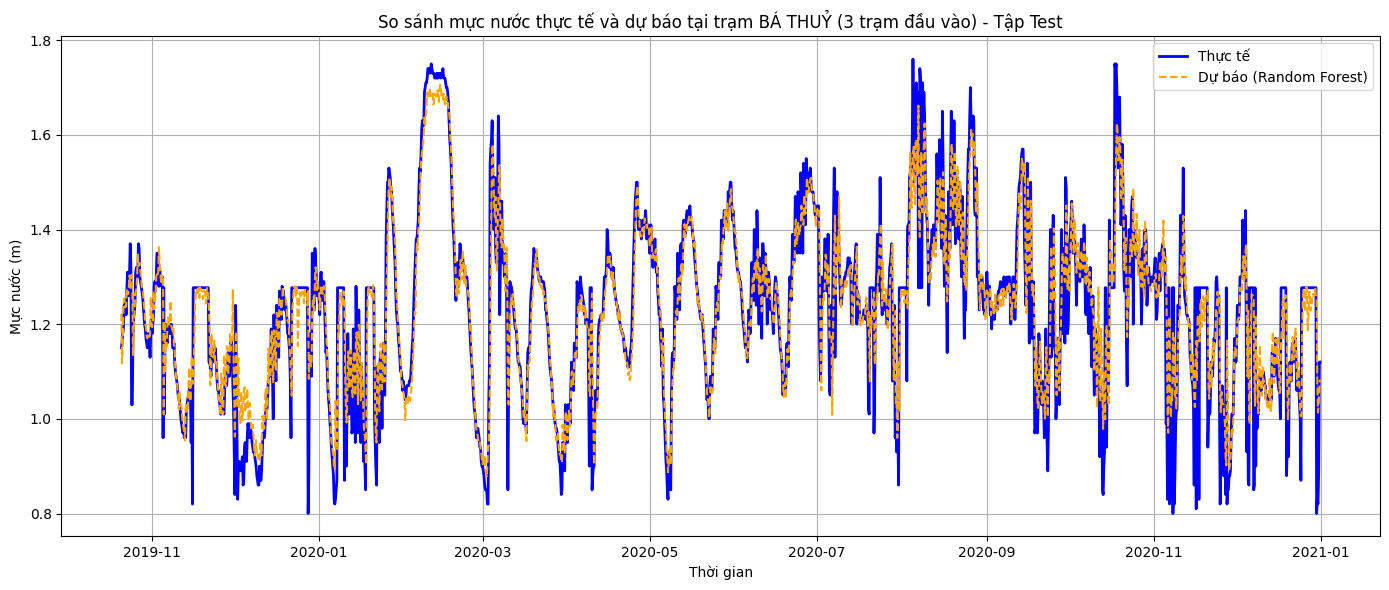

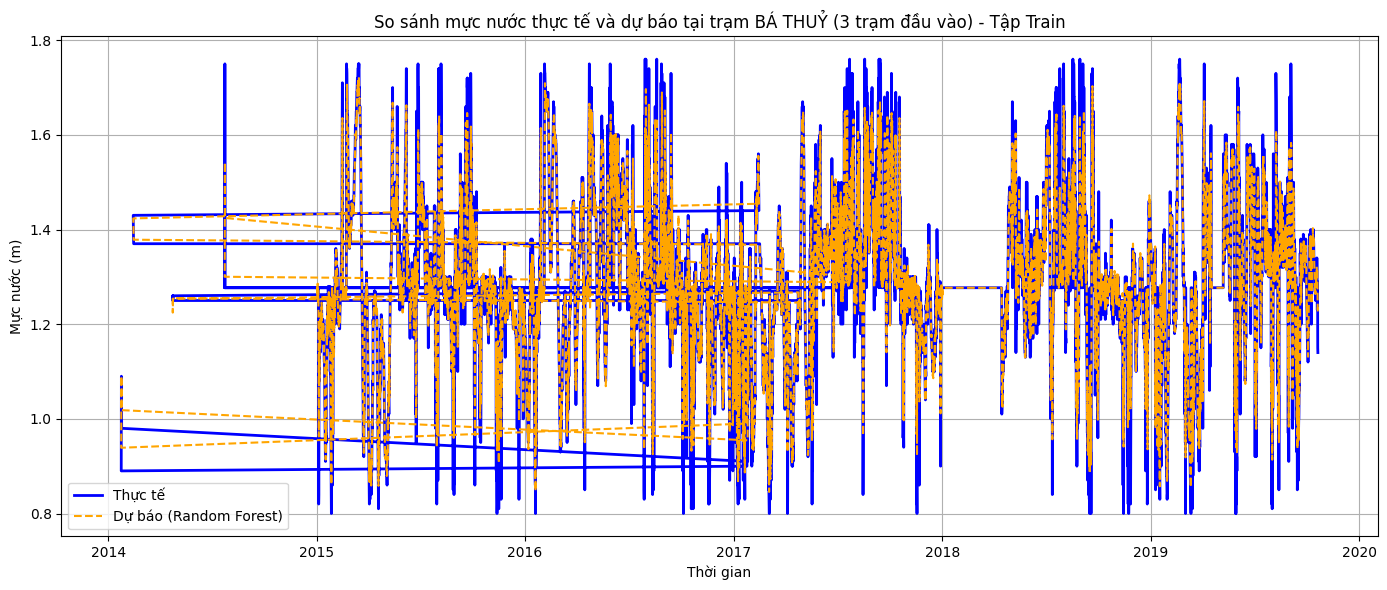

In [5]:
#Dự báo từ 3 trạm(2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. Chọn features và target
feature_cols = ['CẦU CẤT', 'CẦU XE', 'AN THỔ']
target_col = 'BÁ THUỶ'
df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. Tạo đặc trưng trễ
def create_lagged_features(data, feature_cols, target_col, n_lags=3):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

n_lags = 3
df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags)

# 4. Chuẩn bị dữ liệu
X = df_lagged.drop(columns=[target_col])
y = df_lagged[target_col]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42
)

# 6. Huấn luyện mô hình
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 7. Hàm đánh giá
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# 8. Dự đoán TRAIN
y_train_pred_scaled = rf_model.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_orig, y_train_pred)

# 9. Dự đoán TEST
y_test_pred_scaled = rf_model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test_orig, y_test_pred)

# 10. In kết quả
print("\nĐánh giá mô hình trên tập Test:")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2 Score: {r2_test:.4f}")

print("\nĐánh giá mô hình trên tập Train")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")

dates_test = df_lagged.index[-len(y_test):]
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, y_test_pred, label='Dự báo (Random Forest)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (3 trạm đầu vào) - Tập Test')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

dates_test = df_lagged.index[-len(y_test):]
plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_orig, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, y_train_pred, label='Dự báo (Random Forest)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (3 trạm đầu vào) - Tập Train')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Gộp dữ liệu dự đoán và thực tế
y_full_pred = np.concatenate([y_train_pred, y_test_pred])
y_full_true = np.concatenate([y_train_orig, y_test_orig])

# Lấy lại index gốc cho phần dự đoán (vì đã shift và dropna nên phải dùng phần cuối)
index_full = df_lagged.index[-len(y_full_pred):]  # hoặc len(df_lagged) - len(y_full_pred)

# Tạo DataFrame kết quả
df_result = pd.DataFrame({
    'Thời gian': index_full,
    'Giá trị thực tế': y_full_true,
    'Giá trị dự đoán': y_full_pred
}).set_index('Thời gian')

# Hiển thị vài dòng
print("\nDữ liệu dự đoán gộp (Train + Test):")
print(df_result.head())

df_result.to_excel("../Data/du_bao_BA_THUY_RF_3tram.xlsx")


Dữ liệu dự đoán gộp (Train + Test):
                     Giá trị thực tế  Giá trị dự đoán
Thời gian                                            
2015-01-01 19:00:00         1.277022         1.275532
2015-01-02 01:00:00         1.277022         1.277919
2015-01-02 07:00:00         1.277022         1.257648
2015-01-02 13:00:00         1.277022         1.253300
2015-01-02 19:00:00         1.277022         1.271593


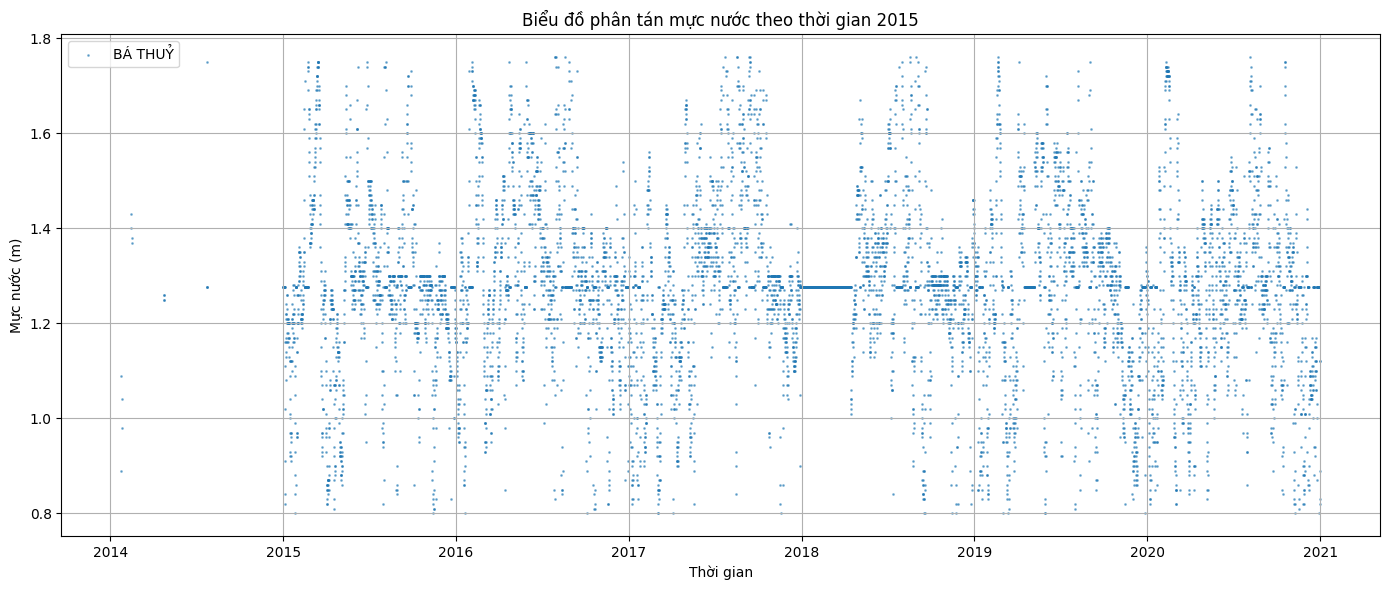

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx", sheet_name="Danh_gia", parse_dates=["Datetime"])

# Giữ lại các cột cần thiết
cols = ['Datetime', 'BÁ THUỶ']
df = df[cols].dropna()

# Vẽ biểu đồ phân tán
plt.figure(figsize=(14, 6))
for col in cols[1:]:
    plt.scatter(df['Datetime'], df[col], s=1, label=col, alpha=0.5)

plt.title("Biểu đồ phân tán mực nước theo thời gian 2015")
plt.xlabel("Thời gian")
plt.ylabel("Mực nước (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
